# Unit 5.7. Evaluating and Using Models on New Data

## Part 2-2. Loading a Model from a Checkpoint & Evaluating the Model

In [1]:
%load_ext watermark
%watermark -p torch,lightning,torchmetrics

torch       : 2.1.2+cu121
lightning   : 2.1.4
torchmetrics: 1.2.0



# Load Model

In [2]:
import lightning as L
import torch
from shared_utilities import PyTorchMLP, LightningModel, MNISTDataModule

In [3]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)

lightning_model = LightningModel.load_from_checkpoint(
    checkpoint_path="model.ckpt", model=pytorch_model)

In [4]:
dm = MNISTDataModule()
dm.setup(stage="test")

# Predict on New Data

In [5]:
import torchmetrics


test_dataloader = dm.test_dataloader()
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

for batch in test_dataloader:
    features, true_labels = batch

    with torch.inference_mode():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]

tensor([1, 2, 3, 4, 5])

As an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [6]:
test_acc = acc.compute()
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.9706 (97.06%)


# Inspecting Failure Cases

In [7]:
class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

In [8]:
import matplotlib.pyplot as plt
from shared_plotting import show_failures

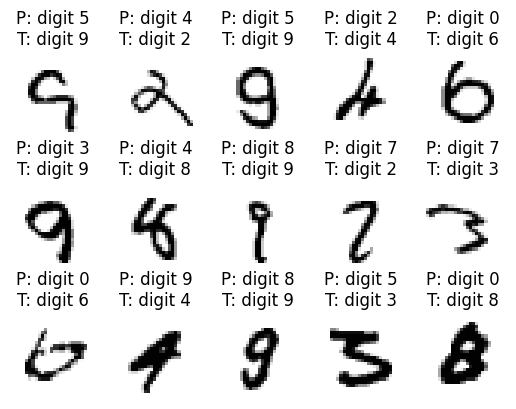

In [9]:
show_failures(
    model=lightning_model, data_loader=test_dataloader, class_dict=class_dict
)

plt.savefig('failures.pdf')

# Plotting A Confusion Matrix

In [10]:
# !pip install mlxtend

In [11]:
%watermark -p mlxtend

mlxtend: not installed



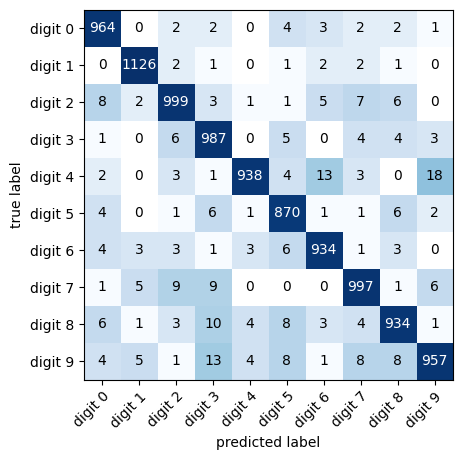

In [14]:
import matplotlib

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in dm.test_dataloader():

    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()